<a href="https://colab.research.google.com/github/UniVR-DH/ADHLab/blob/main/lecture06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Page Rank of pages

We will use the Spacy Library:
https://spacy.io/usage/spacy-101

and the NetworkX Library:
https://networkx.org/documentation/stable/tutorial.html

and we will get code produced by ChatGPT
https://chat.openai.com/


<img src="https://drive.google.com/uc?export=view&id=1m_EMdnI5C826kgqK7r5vB4TXnB0-Wq7W" alt="Intestazione con loghi istituzionali" width="525"/>

| Docente      | Insegnamento | Anno Accademico    |
| :---        |    :----   |          ---: |
| Matteo Lissandrini      | Laboratorio Avanzato di Informatica Umanistica       | 2023/2024   |

## Usual install and basic imports

In [1]:
%pip install wikipedia-api
%pip install spacy==3.7.0
%pip install networkx
%pip install beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.0 which is incompatible.


In [28]:
import wikipediaapi
import re


def get_wikipedia_page_links(title, wiki_wiki, valid_pages):
    page_py = wiki_wiki.page(title)

    links = page_py.links
    valid_links = set()
    for next_page in links.values():
      try: # We use a "try" to skip in case of errors
        page_title = next_page.title

        if page_title in valid_pages:
          valid_links.add(page_title)

      except Exception as ex:
        print("\tError retrieving", next_page.title)
    print("Found {} and kept {} links".format(len(links), len(valid_links)))
    return valid_links

In [34]:
import networkx as nx

def build_directed_graph(page_links):
    G = nx.DiGraph()

    for page_title, links in page_links.items():
        # Add nodes and edges to the graph
        G.add_node(page_title)
        for link in links:
            if link in page_links:
                G.add_edge(page_title, link)
            break
    return G

In [36]:
import matplotlib.pyplot as plt


wiki_wiki = wikipediaapi.Wikipedia('MyTestProjectName (my.name@univr.it)',
                                'en',
                                extract_format=wikipediaapi.ExtractFormat.WIKI)

# List of Wikipedia pages on Space Exploration
space_exploration_pages = [
    'Space_exploration',
    'Human_spaceflight',
    'Space_race',
    'Space_Shuttle',
    'International_Space_Station',
    'Space_telescope',
    'Mars_rover',
    'Spacecraft',
    'Astronaut',
    'Extraterrestrial_life',
    'Satellite',
    'Space_colonization',
    'Interplanetary_spaceflight',
    'Apollo_program',
    'Exoplanet',
    'SpaceX',
    'Cosmic_ray',
    'Lunar_module',
    'Voyager_program',
    'Astrobiology',
    'Space_law',
    'Space_tourism',
    'Orbital_mechanics',
    'Planetary_protection',
    'Astrophysics'
]

valid_pages = set()

for title in space_exploration_pages:
  page_py = wiki_wiki.page(title)
  if page_py.exists():
    valid_pages.add(page_py.title)
  else:
    print("Page '{}' does not exists".format(title))



# Instantiate a dictionary to store the links between pages
page_links = {}

# Get links for each page
for page_title in valid_pages:
    links = get_wikipedia_page_links(page_title, wiki_wiki, valid_pages)
    page_links[page_title] = links

# Print the extracted links
# for page_title, links in page_links.items():
#    print("Links from '{}': {}".format(page_title, len(page_links[page_title])))
#    for link in links:
#        print(f"  - {link}")

space_exploration_graph = build_directed_graph(page_links)
print(len(space_exploration_graph))

Found 481 and kept 7 links
Found 1690 and kept 18 links
Found 920 and kept 10 links
Found 500 and kept 14 links
Found 486 and kept 11 links
Found 980 and kept 17 links
Found 813 and kept 6 links
Found 1644 and kept 15 links
Found 362 and kept 15 links
Found 736 and kept 16 links
Found 335 and kept 4 links
Found 550 and kept 17 links
Found 438 and kept 8 links
Found 611 and kept 7 links
Found 465 and kept 16 links
Found 611 and kept 5 links
Found 2509 and kept 16 links
Found 557 and kept 2 links
Found 1043 and kept 12 links
Found 1263 and kept 18 links
Found 1889 and kept 17 links
Found 1250 and kept 18 links
Found 634 and kept 14 links
Found 35 and kept 2 links
Found 400 and kept 16 links
25


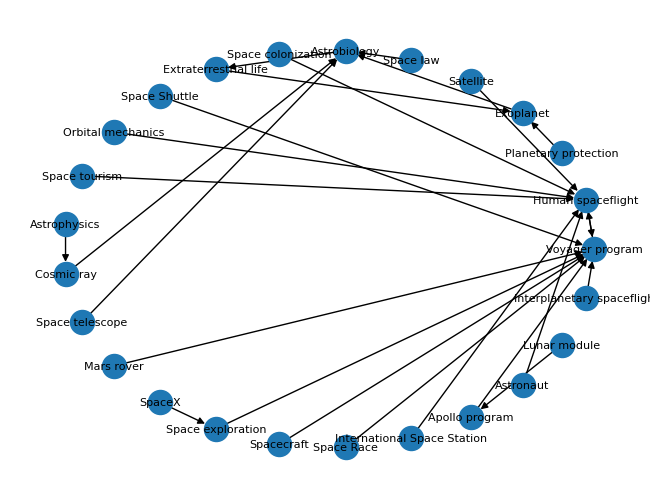

In [37]:
pos = nx.circular_layout(space_exploration_graph)
nx.draw(space_exploration_graph, pos, with_labels=True, font_size=8, font_color='black', node_size=300)
plt.show()

In [38]:
import pandas as pd

def calculate_pagerank(graph):
    return nx.pagerank(graph)

def display_pagerank_table(pagerank_scores):
    df = pd.DataFrame(list(pagerank_scores.items()), columns=['Page Title', 'PageRank Score'])
    df = df.sort_values(by='PageRank Score', ascending=False).reset_index(drop=True)
    display(df)


# Calculate PageRank scores
pagerank_scores = calculate_pagerank(space_exploration_graph)

# Display the PageRank scores in a table
display_pagerank_table(pagerank_scores)

,Page Title,PageRank Score
0,Voyager program,0.293620
1,Human spaceflight,0.286180
2,Astrobiology,0.102120
3,Extraterrestrial life,0.092804
4,Exoplanet,0.089976
5,Apollo program,0.011100
6,Space exploration,0.011100
7,Cosmic ray,0.011100
8,Mars rover,0.006000
9,Lunar module,0.006000
